# Analyse de données - TP4 : t-SNE et LLE

Dans les sessions précédentes de ce cours, nous avons déjà découvert certaines méthodes de réduction de dimension / visualisation de données: PCA, MDS et Isomap. Dans cette session, nous continuons sur notre lancée avec t-SNE (t-distributed Stochastic Neighbor Embedding) et LLE (Locally Linear Embeddings). La plupart de ces méthodes peuvent être trouvées prêtes à l'emploi via le module [`manifold learning`](http://scikit-learn.org/stable/modules/manifold.html).

Nous faisons, comme d'habitude, les imports en haut du fichier. Jetez-y un oeil maintenant, vous aurez certainement besoin de certains de ces modules plus tard.

In [1]:
# Les imports sont en haut du fichier
from sklearn import manifold, decomposition, datasets, neighbors
from mpl_toolkits.mplot3d import axes3d, Axes3D # utile pour afficher en 3D
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import describe
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

Nous allons utiliser un jeu de données "jouet" pour observer les effets des différentes méthodes. Le jeu de données que nous allons utiliser est *swiss roll*. Il porte ce nom car il génère des points dont la forme 3D évoque celle des gateaux roulés suisses.

![Gateau roulé suisse](https://static.750g.com/images/600-600/461a30416d01af9d46ebd89589fda45d/gateau-roule-au-nutella.png "Gateau roulé suisse")


_Le saviez-vous? L'argument `random state` permet de fixer l'état aléatoire afin d'obtenir toujours les même points à chaque exécution. Par défaut, l'ordinateur utilise l'horloge du processeur pour fixer son état aléatoire afin qu'il soit différent à chaque exécution (la, la, la : lors de la lecture de ces trois "la", le temps de l'horloge était unique et différent à chaque fois). Pour rendre vos résultats reproductibles, il est important que vous utilisiez et notiez les "états aléatoires" (habituellement appelés *seed*)._

In [2]:
# Creer le dataset
n_points = 1000
X, pos = datasets.make_swiss_roll(n_samples=n_points, random_state=0)

**Exercice**
- Faites une première analyse de ces données: quelle est leur dimension?

In [3]:
X.shape

(1000, 3)

Pour visualiser ces données en 3D, définissons une fonction dédiée:

In [4]:
def scatter3D(X, Y, Z, colors=(), title=""):
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    ax.scatter(X, Y, Z, c=colors, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.show()

Définissons aussi une fonction de visualisation en 2D

In [5]:
def scatter2D(X, Y, title="", colors=()):
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(X, Y, c=colors, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.show()

A présent, utilisons ces deux fonctions pour afficher nos données (sans les transformer à l'avance):

**Exercice**
- Utiliser les deux fonctions `scatter3D` et `scatter2D` (prendre les dimensions 0 et 1 par exemple) pour visualiser les données dans leur état brut
- Commentez

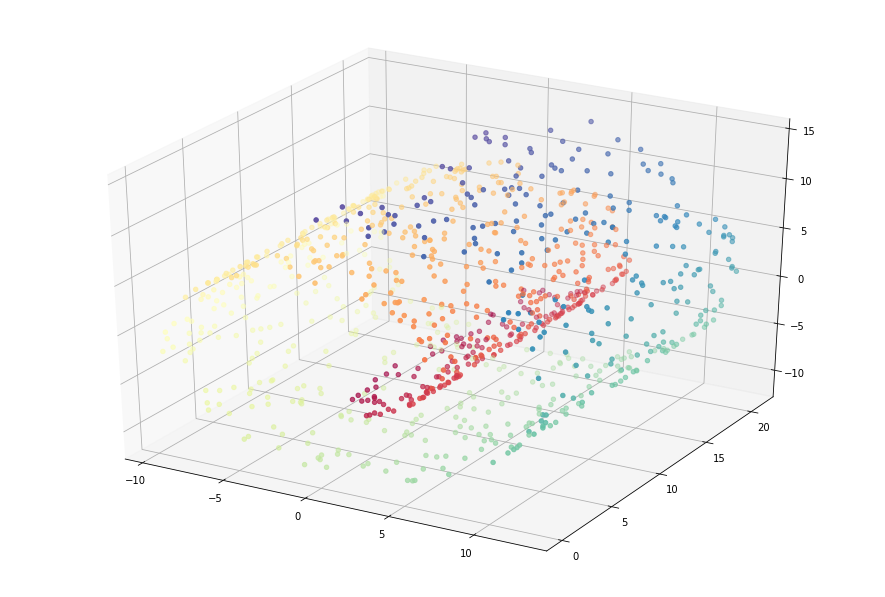

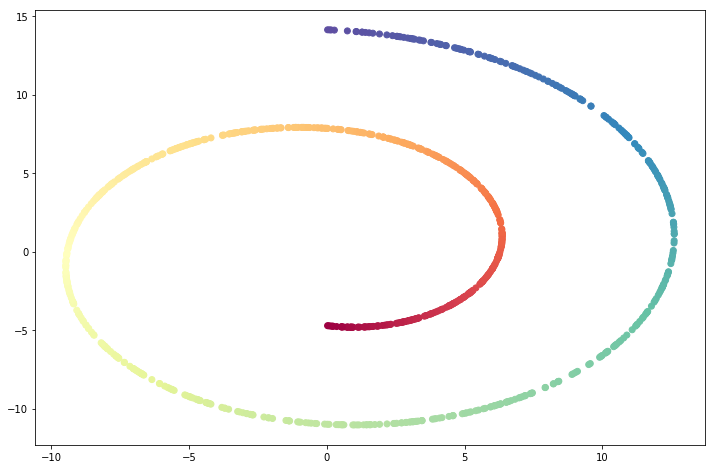

In [6]:
scatter3D(X[:, 0], X[:, 1], X[:, 2], pos)
scatter2D(X[:, 0], X[:, 2], colors=pos)

**Réponse:**
- Les points forment un spectre de couleurs cohérent
- Les points sont enroulés

Maintenant que nous voyons que la visualisation en deux dimensions n'est pas particulièrement plus claire que la visualisation en 3D, essayons d'y appliquer les méthodes de visualisation que nous avons vu précédemment:
PCA, MDS et IsoMap.

**Exercice**
- Utiliser les classes PCA, MDS et Isomap de sklearn pour réduire la dimension de ces données (dimension 2) (utilisez 10 comme nombre de voisins pour Isomap)
- Affichez les résultats obtenus en 2D avec chacune des méthodes
- Commentez: quelle méthode semble être la "meilleure"? Pourquoi ce choix? Une intuition de comment?

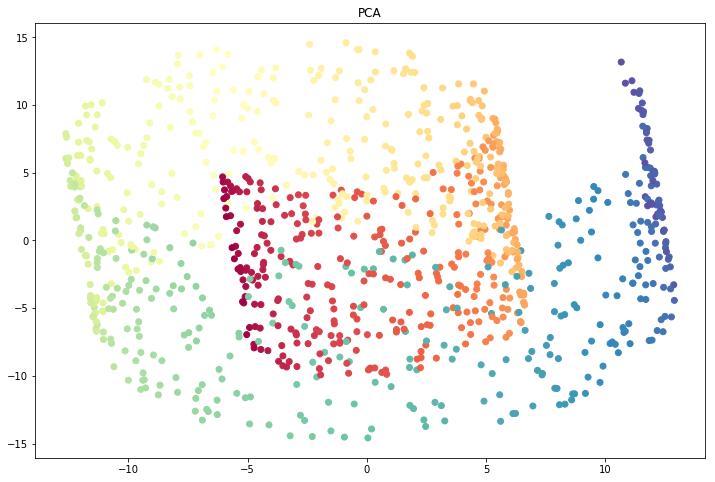

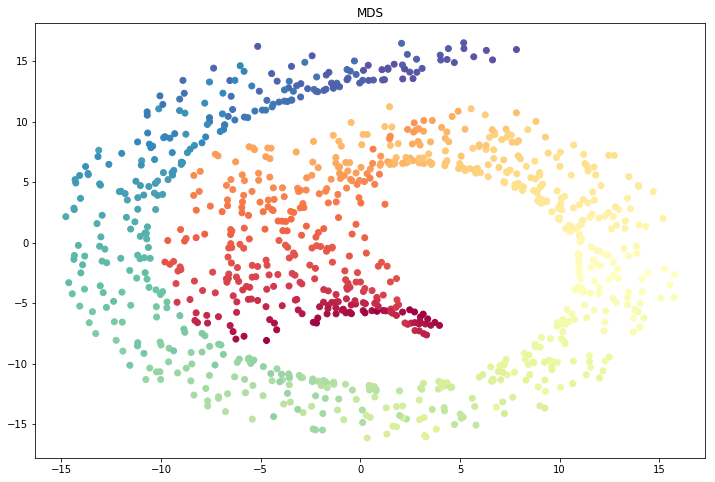

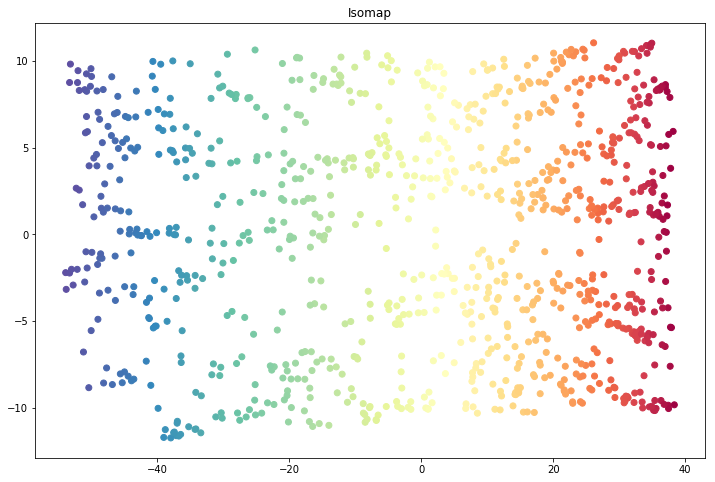

In [7]:
n_components = 2

pca = decomposition.PCA(n_components)
Xpca = pca.fit_transform(X)
scatter2D(Xpca[:, 0], Xpca[:, 1], title="PCA", colors=pos)

mds = manifold.MDS(n_components, n_init=1)
Xmds = mds.fit_transform(X)
scatter2D(Xmds[:,0], Xmds[:,1], title="MDS", colors=pos)

n_neighbors = 10 # le nombre de voisins à utiliser pour la méthode Isomap
isomap = manifold.Isomap(n_neighbors, n_components)
Xiso = isomap.fit_transform(X)
scatter2D(Xiso[:,0], Xiso[:,1], title="Isomap", colors=pos)

**Réponse:**
- Isomap semble meilleur
- On voit que les données sont bien linéairement séparées par couleurs (on peut tracer une droite entre les données)
- Les relations entre voisins sont préservées: dépendances courte distance

A présent, faisons la même chose avec les algorithmes t-SNE et LLE

## t-distributed Stochastic Neighbour Embedding (t-SNE)

L'algorithme t-SNE, comme MDS et Isomap, vise à réduire la dimension des données tout en préservant une propriété des données dans l'espace de description initial. Cependant, du point de vue de la mise en oeuvre, cette similarité se résume à la construction d'une matrice de similarités. 

Dans les grandes lignes, on peut dire que l'algorithme t-SNE identifie la distribution des distances entre données dans l'espace de description initial puis génère les nouvelles coordonnées dans l'espace de plus basse dimension. Les coordonnées dans le nouvel espace sont choisies telles qu'elles respectent la distribution des distances entre données dans l'espace initial. Etape par étape, cela donne:

1. Calculer les distances euclidiennes entre les données: construire la matrice des distances;
2. Convertir les distances en probabilités conditionnelles: la distance entre $x_i$ et $x_j$ ($p_{i,j}$) donne la probabilité que $x_j$ soit un "voisin" de $x_i$ suivant une distribution Gaussienne de moyenne $x_i$ et d'écart type $\sigma$ (un hyper-paramètre à définir en fonction des données). Si deux points sont proches, alors la probabilité qui leur est associée est grande;
3. Trouver les points dans l'espace de petite dimension dont les probabilités entre points sont les même que dans l'espace de plus grande dimension.

### Calculer les probabilités conditionnelles

Notez l'utilisation de $\sigma$ qui rend compte de la densité des points.

$p_{i|j} = \frac{\exp(-\|x_i-x_j \|^2/2\sigma_i^2)}{\sum_{k\neq i} \exp(-\|x_i-x_k \|^2/2\sigma_i^2)}$ .

### Trouver les points dans l'espace de petite dimension

La distribution des distances dans l'espace de petite dimension doit être la même que celle dans l'espace de description initial. Il est possible d'avoir une mesure de la différence entre deux distributions grâce à la formule de la divergence de Kullback-Leibler (KL). Nous pouvons donc poser le problème d'optimisation suivant:

$\min \sum_i KL(P_i||Q_i) = \min \sum_{i,j}p_{j|i}\frac{p_{j|i}}{q_{j|i}}$

où on cherche simplement à minimiser cette distance pour tous les points (chaque point à sa distribution de distance, n'est-ce-pas?). Si la différence est nulle alors les distributions sont identiques.

Notez toutefois que ce problème d'optimisation n'est pas convexe: deux exécutions successives de t-SNE ne donneront donc certainement pas deux fois les même coordonnées.

### Lien vers une super vidéo Youtube qui explique t-SNE

https://www.youtube.com/watch?v=NEaUSP4YerM

## Localy Linear Embedding (LLE)

L'algorithme LLE est encore une fois similaire aux trois autres algorithmes vus précédemment: on cherche à réduire la dimension en préservant une propriété des données dans l'espace de description initial. Cependant, cette méthode ce démarque de MDS et t-SNE car elle n'utilise pas une mesure de distance entre les données (enfin, pas aussi directement): elle repose sur l'expression de chaque donnée par une combinaison linéaire de ses plus proches voisins. Dans l'espace de description initial, on exprime chaque point comme une combinaison linéaire de ses voisins puis on cherche les coordonnées des points dans l'espace de description réduit de telle façon que cette combinaison linéaire de voisins soit préservée. Etape par étape, ça donne:

1. Trouver les plus proches voisins de chaque point;
2. Trouver les poids pour approximer chaque point comme une combinaison linéaire de ses voisins;
3. Trouver les nouvelles coordonnées des points de façon à pouvoir utiliser les poids précédemment trouvés pour approximer les nouveaux points comme combinaison linéaire de ses voisins.

### Trouver les poids

Les poids idéaux sont ceux tels que la différence entre un point et la combinaison linéaire des voisins de ce point (étant donné les poids idéaux) soit nulle. Ceci revient au problème d'optimisation suivant:

$argmin_{\mathbf{w}} \sum_{i=1}^n \| x_i -\sum_{j\neq i} w_{ij}x_j \|^2$

(Choisir w = 0 pour les points qui ne sont pas voisins)

### Trouver les nouvelles coordonnées

Etant donné les poids idéaux trouvés précédemment, nous cherchons les points dans le nouvel espace tels que la différence entre chaque point et la combinaison linéaire de ses voisins (étant donné les poids idéaux) soit nulle. Ceci revient au problème d'optimisation suivant:

$argmin_{y} \sum_{i=1}^n \| y_i -\sum_{j\neq i} w_{ij}y_j \|^2$

**Exercice**
- Utiliser les classes `LocallyLinearEmbedding` et `TSNE` de `sklearn` pour calculer les coordonnées des données en dimension 2
- Afficher les résultats en 2D
- Commentez

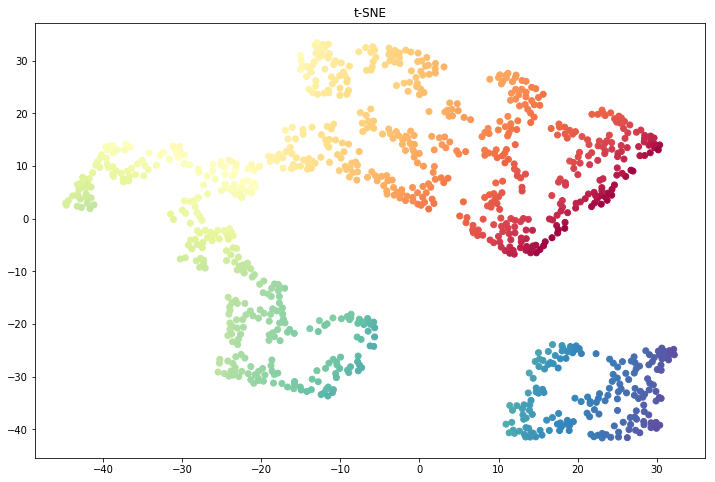

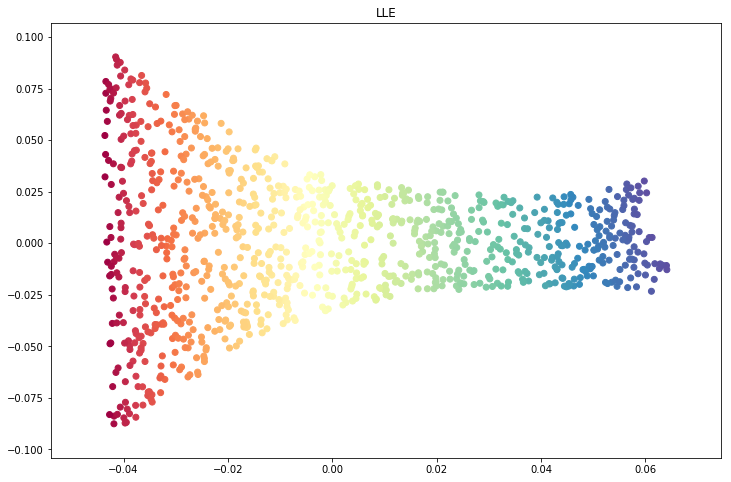

In [8]:
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Xtsne = tsne.fit_transform(X)
scatter2D(Xtsne[:,0], Xtsne[:,1], title="t-SNE", colors=pos)

n_neighbors = 10 # le nombre de voisins à utiliser pour la méthode LLE
lle = manifold.LocallyLinearEmbedding(n_neighbors, n_components)
Xlle = lle.fit_transform(X)
scatter2D(Xlle[:,0], Xlle[:,1], title="LLE", colors=pos)

**Réponse**
- LLE meilleur que t-SNE
- t-SNE cherche des clusters alors qu'il n'y en a pas

## Exercice final: Evaluation des méthodes

*Le saviez vous? Il existe des programmes qui permettent de détecter le plagiat entre documents de sources différentes... hihihihi.*

Pour cet exercice, vous allez simplement devoir mettre en application et comparer chacune des techniques vues pendant ce cours sur un jeu de données. Le jeu de données MNIST.

*Le saviez-vous? MNIST est le jeu de données équivalent au "Hello, World!" de la classification en apprentissage automatique. Ce jeu de données contient des images de chiffres écris à la main ainsi que la classe qui leur est associée (le chiffre écrit sur chaque image)*

In [9]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
X, y = mnist.data / 255.0, mnist.target
possible_labels = np.unique(y)

Visualisons à présent ces fameux chiffres écris à la main:

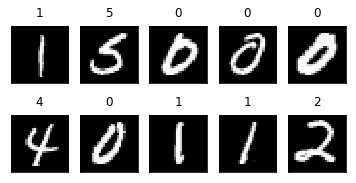

In [10]:
nrows, ncols = 2, 5 # nous allons montrer les chiffres sur une grille de deux lignes et cinq colonnes
plt.figure(figsize=(6,3)) 
plt.gray() # en noir et blanc
for i in range(ncols * nrows):
    j = np.random.randint(X.shape[0]) # on choisit un exemple au hasard à afficher
    ax = plt.subplot(nrows, ncols, i + 1) # on selectionne l'élément de la grille sur lequel on va afficher
    ax.matshow(X[j].reshape((28,28))) # on fait l'affichage en transformant les vecteurs d'image en matrices
    plt.xticks([]); plt.yticks([]) # supprime les graduations du graphique
    plt.title(int(mnist.target[j])) # affiche la classe associée à chaque image en titre de l'image
plt.show()

**Exercice:**
- Donnez des détails sur les données
- Affichez les dimensions 501, 502 et 503 de MNIST sur des graphiques en 2D et 3D (les dimensions ont été choisies arbitrairement)
- Commentez

(70000, 784) 0.0 1.0 [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
(70000,)


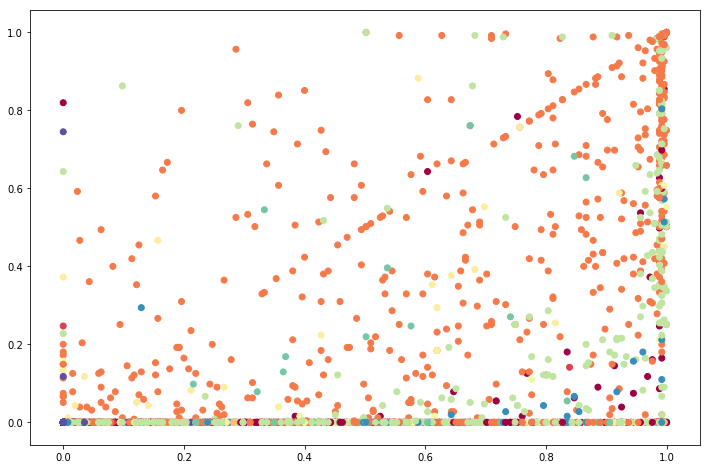

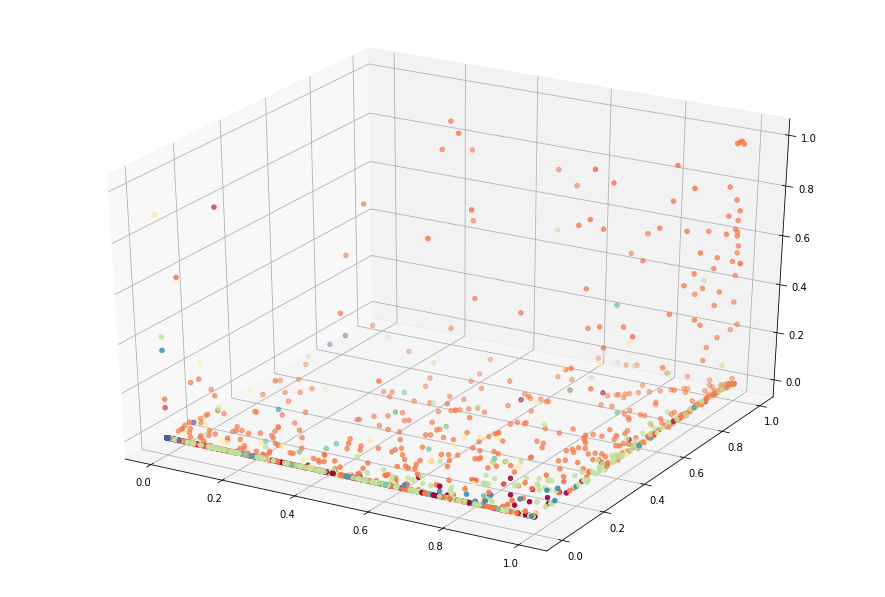

In [11]:
print(X.shape, np.min(X), np.max(X), possible_labels)
print(y.shape)
scatter2D(X[:, 500], X[:, 501], colors=y)
scatter3D(X[:, 500], X[:, 501], X[:, 502], colors=y)

Intuitivement, dans le cadre de données comme MNIST où chaque point appartient à une classe, on peut se dire que la réduction de dimension est efficace si les points d'une même classe apparaissent proche dans l'espace de faible dimension. Dans nos exemples avec *swiss roll*, les point bleus étaient à coté des points bleus et les points rouges étaient à coté des points rouges et... on était content parce que ça faisait des figures homogènes.

Cela dit, le fait qu'on soit contents ou pas ne constitue pas une mesure d'efficacité satisfaisante dans une démarche scientifique. Heureusement, il est possible de transformer ce degrés de contentement en nombre grâce à la classification par la méthode des plus proches voisins. (entre autres, en tout cas on va utiliser ça dans ce TP)

### Les plus proches voisins

La classification par les plus proches voisins est la technique la plus simple (à mon avis) de classification en apprentissage automatique qui consiste à définir la classe d'un point inconnu comme étant la classe majoritaire parmi ses plus proches voisins connus. Ne vous laissez pas berner par la simplicité de cette méthode: elle est en fait extrêmement efficace dans certains cas de figure pour lesquels il est inutile de déployer l'artillerie lourde.

Nous allons voir un exemple de classification de MNIST utilisant la méthode des plus proches voisins. Mais d'abord, nous devons:

- Utiliser un sous-échantillon de MNIST car la méthode des plus proches voisins prendra trop de temps avec le jeu de données complet
- Séparer notre jeu de données X,y en un ensemble d'entrainement (les points connus) et un ensemble de test (les points inconnus sur lesquels nous allons tester la classification). 

**Vous devrez faire les même opérations lorsque vos données auront été transformées tout à l'heure.**

In [12]:
data_size = 1000 # la taille finale que nous utiliserons pour le jeu de données
shuffled_indexes = np.random.permutation(X.shape[0]) # les indices mélangés du jeu de données
X_sub, y_sub = X[shuffled_indexes[:data_size]], y[shuffled_indexes[:data_size]]
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.33)

Maintenant, nous allons utiliser le classifieur des plus proches voisins fourni par `sklearn` pour faire la classification dans l'espace de description initial. Vous devrez plus tard appliquer la même méthode pour faire la classification dans les espaces de dimension réduite que vous aurez créé.

In [13]:
n_neighbors = 15 # le nombre de voisins à regarder pour prendre une décision

clf = neighbors.KNeighborsClassifier(n_neighbors) # créer le classifieur
clf.fit(X_train, y_train) # donner les données connues avec leur étiquette au classifieur
y_pred = clf.predict(X_test) # réaliser la prédiction
accuracy = accuracy_score(y_test, y_pred) # calcul du taux de prédiction exact
print(f"Score de classification correctes: {accuracy*100:.2f} %")

Score de classification correctes: 83.64 %


Super! Tout à l'heure, lorsque vous évaluerez vos méthodes, vous devrez appliquer la méthode des plus proches voisins sur les données obtenues à l'issu de chaque transformation. Meilleur est le score, meilleure est la méthode de transformation.

**Exercice** (il est fortement conseillé de faire des boucles pour gagner du temps...)
- Préparez des sous ensemble de X de taille 1000, 2000, 5000 et 10000. Les prochaines questions doivent être appliquées à tous les sous ensembles de données;
- Faire une PCA pour réduire la dimension des données en dimension **50** (habituellement, ça améliore les choses par la suite). Vous travaillerez par la suite avec ce jeu de données de dimension réduite;
- Utilisez chacune des méthodes vues dans le module DANA (PCA, MDS, Isomap, t-SNE et LLE) pour réduire la dimension des données en dimension 2 ou 3 (choisissez). Pour les méthodes qui nécessitent un choix de nombre de plus proche voisin, faites un choix entre 50 et 100. Pour chacune des méthodes, stockez le temps nécessaire à son exécution (module `time`)
- Dans chaque cas, faites un affichage des données en 2D ou 3D (suivant votre choix à la question précédente). Pour les couleurs, aidez vous de l'exemple que j'ai donné sur les données non transformées... et essayez de le comprendre;
- Commentez;
- Dans chaque cas, évaluez la qualité de la représentation grâce à la méthode des plus proches voisins;
- Commentez;
- Tracez les courbes du temps d'exécution en fonction de la taille du jeu de données pour chacune des méthodes (et sur une seule figure);
- Commentez.

(1000, 50)
(3350, 50) (3350,)
start transformation with PCA and 2 components
(1000, 2)
Start classification


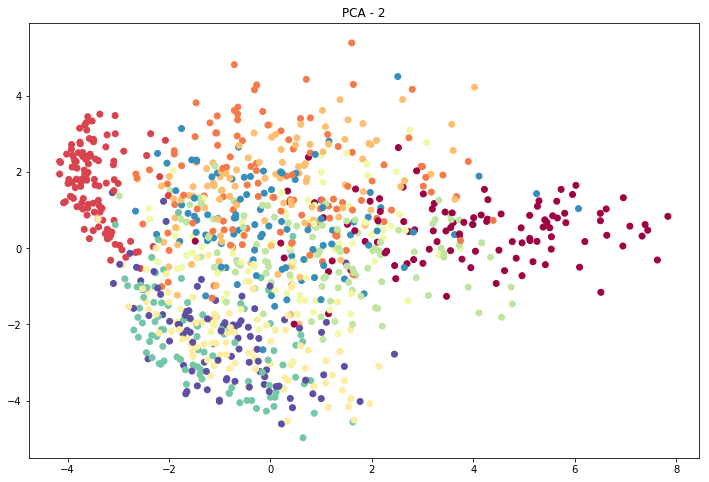

start transformation with PCA and 3 components
(1000, 3)
Start classification


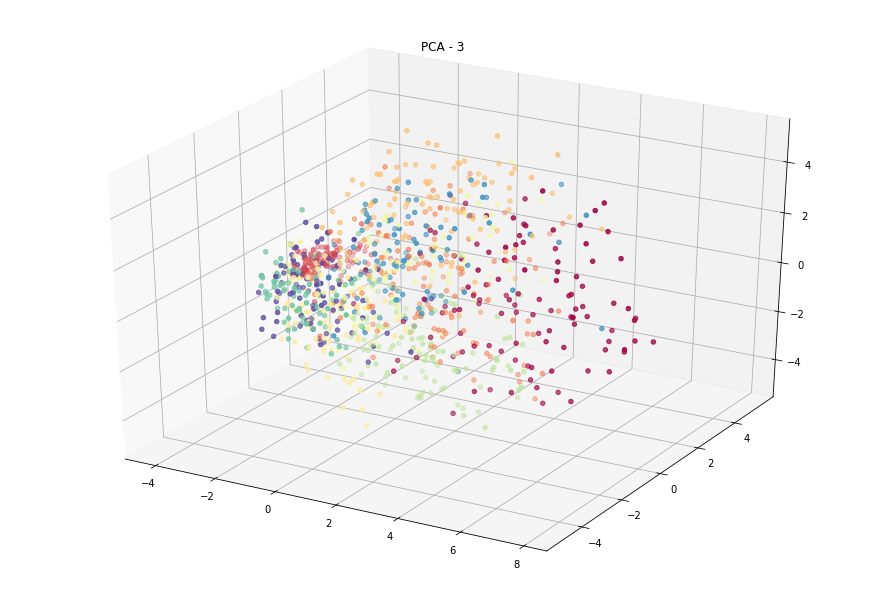

start transformation with MDS and 2 components
(1000, 2)
Start classification


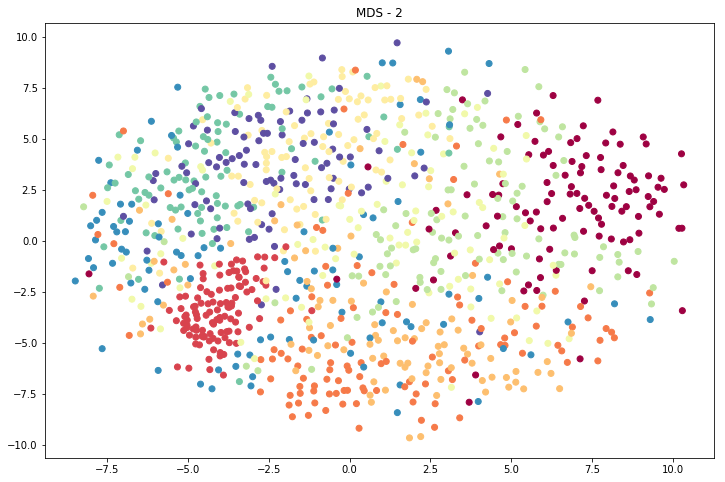

start transformation with MDS and 3 components
(1000, 3)
Start classification


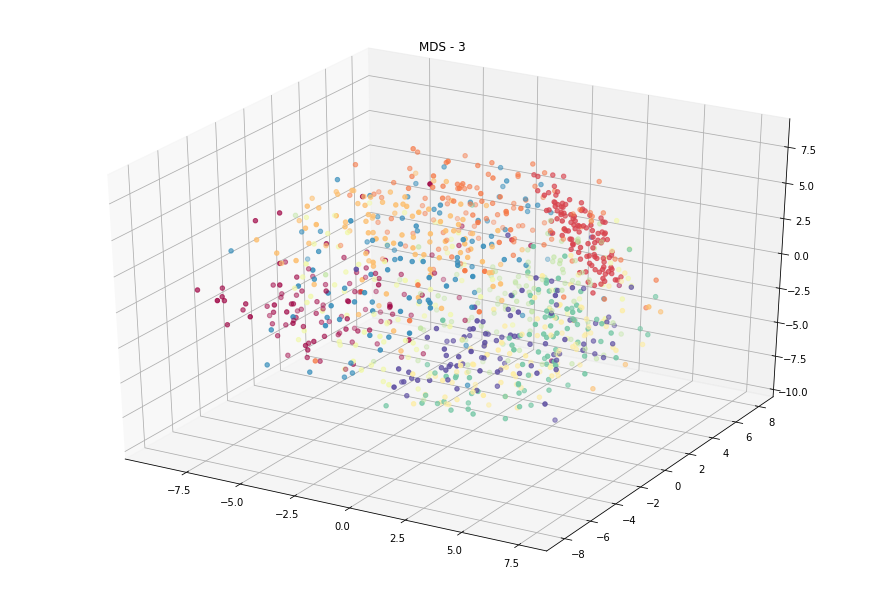

start transformation with Isomap and 2 components
(1000, 2)
Start classification


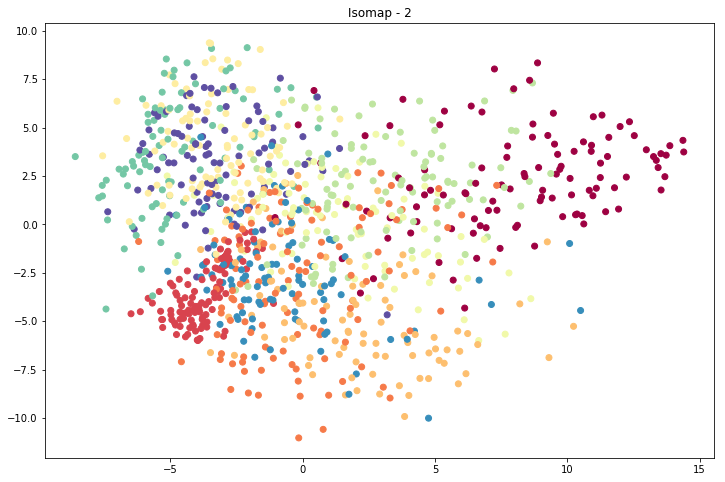

start transformation with Isomap and 3 components
(1000, 3)
Start classification


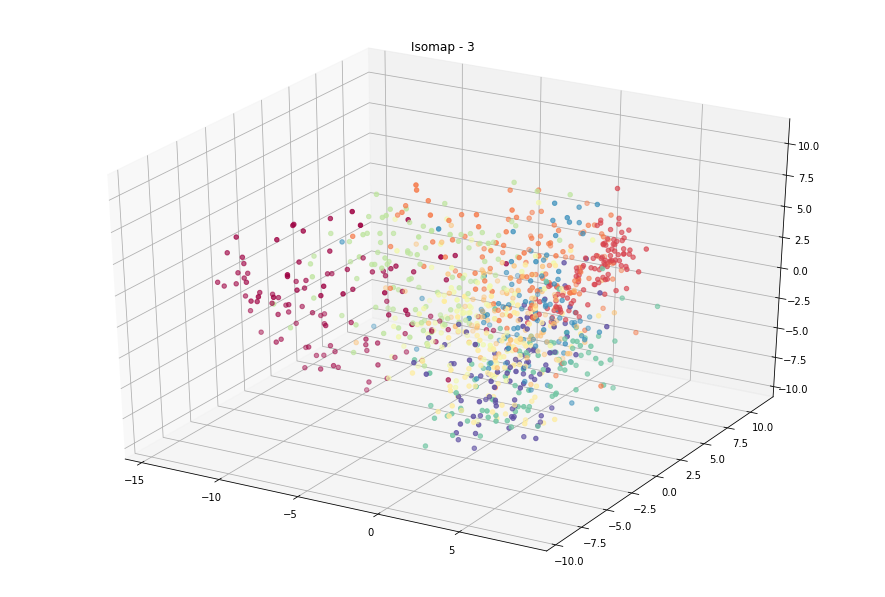

start transformation with t-SNE and 2 components
(1000, 2)
Start classification


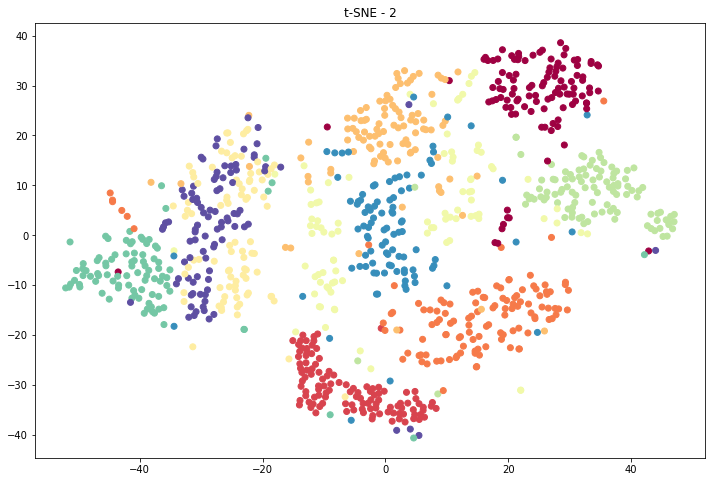

start transformation with t-SNE and 3 components
(1000, 3)
Start classification


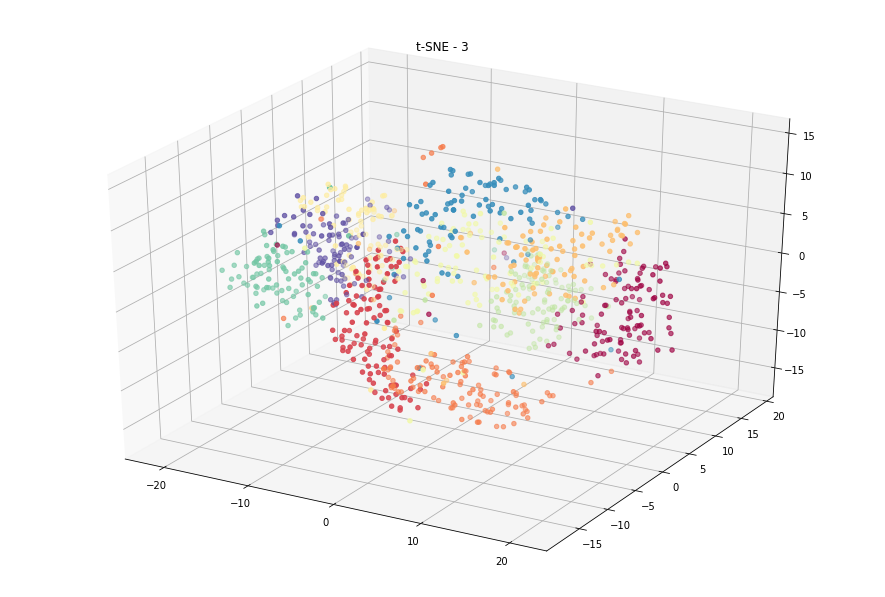

start transformation with LLE and 2 components
(1000, 2)
Start classification


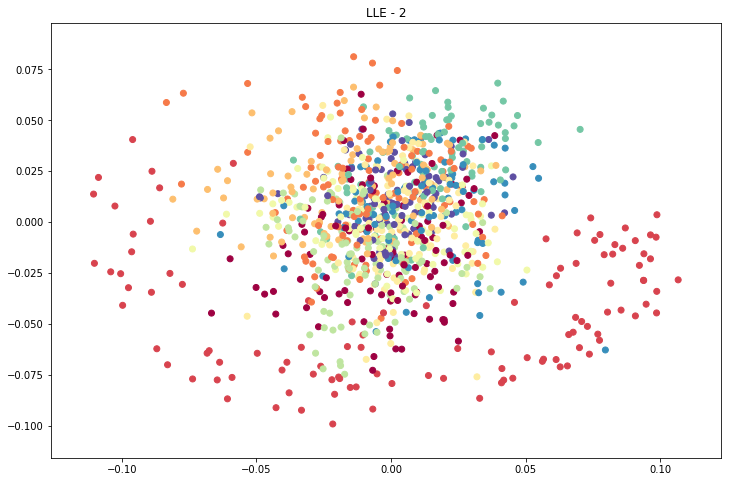

start transformation with LLE and 3 components
(1000, 3)
Start classification


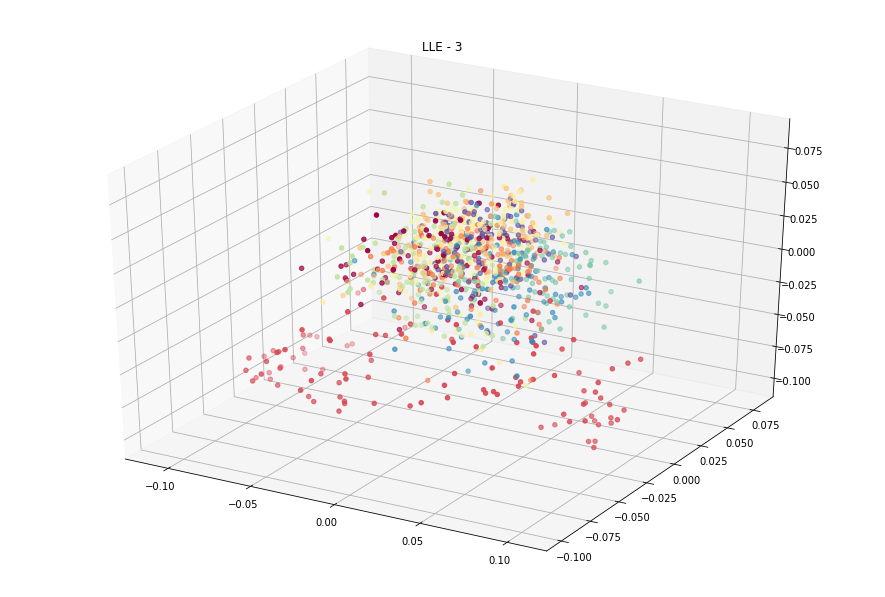

(2000, 50)
(670, 3) (670,)
start transformation with PCA and 2 components
(2000, 2)
Start classification


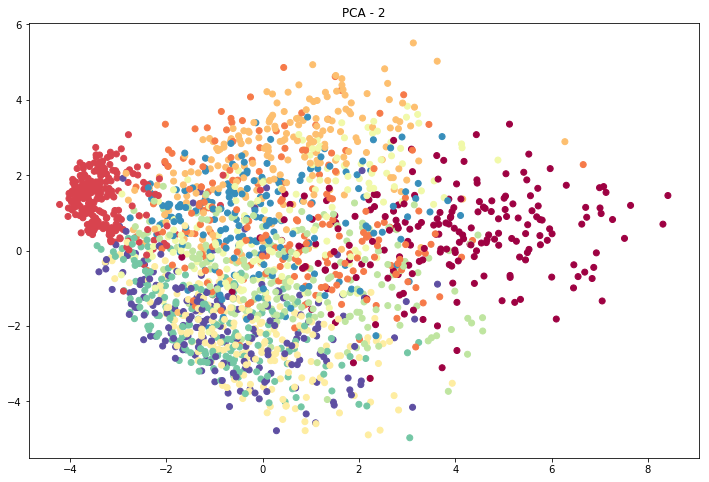

start transformation with PCA and 3 components
(2000, 3)
Start classification


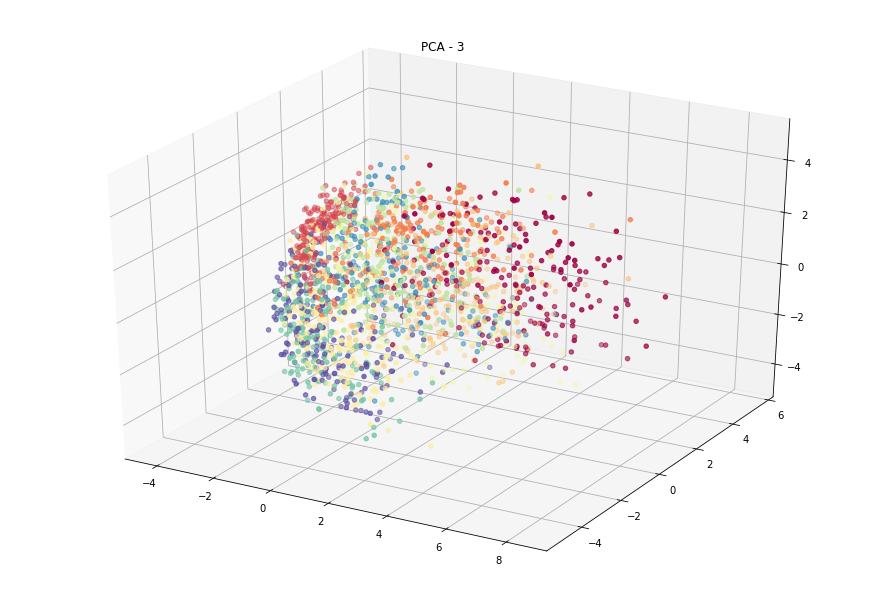

start transformation with MDS and 2 components
(2000, 2)
Start classification


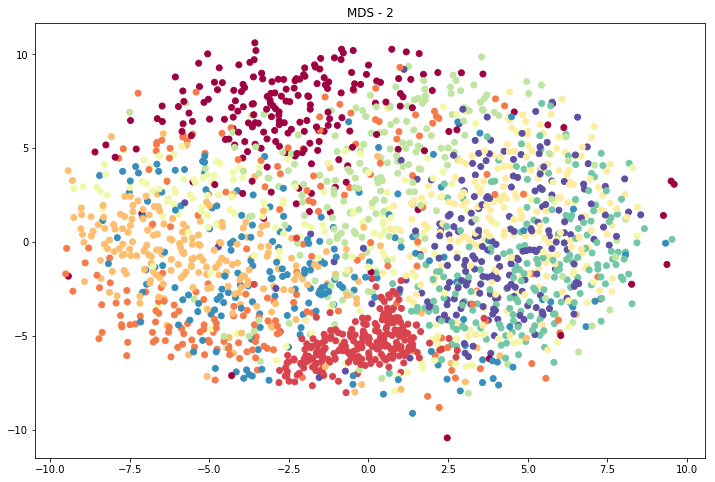

start transformation with MDS and 3 components
(2000, 3)
Start classification


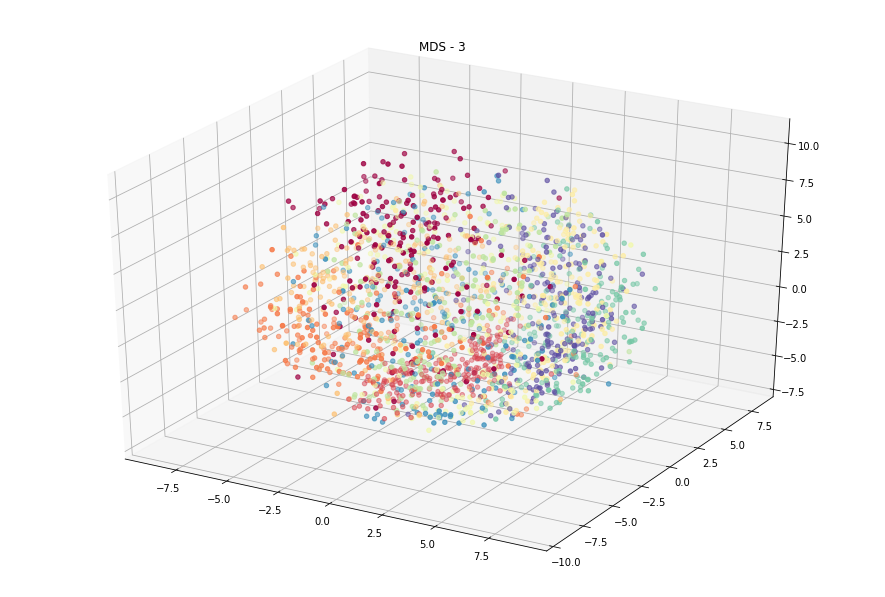

start transformation with Isomap and 2 components
(2000, 2)
Start classification


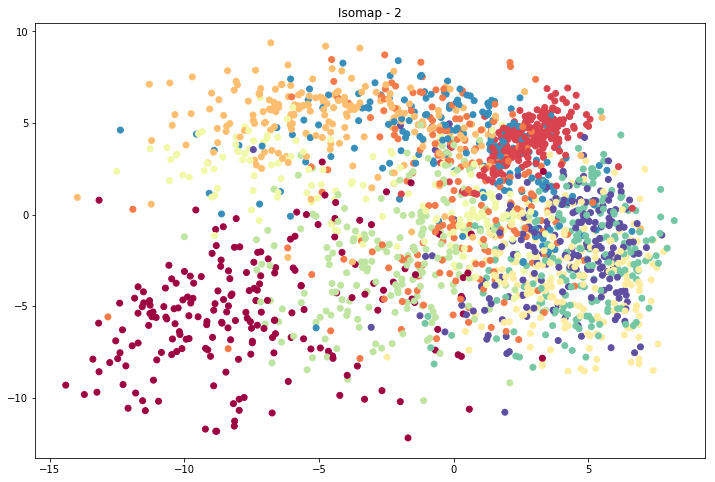

start transformation with Isomap and 3 components
(2000, 3)
Start classification


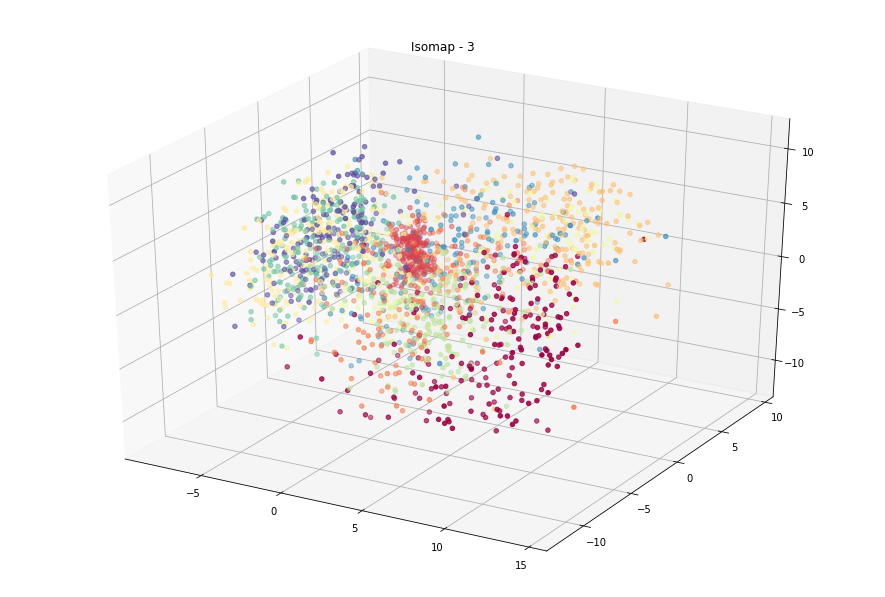

start transformation with t-SNE and 2 components
(2000, 2)
Start classification


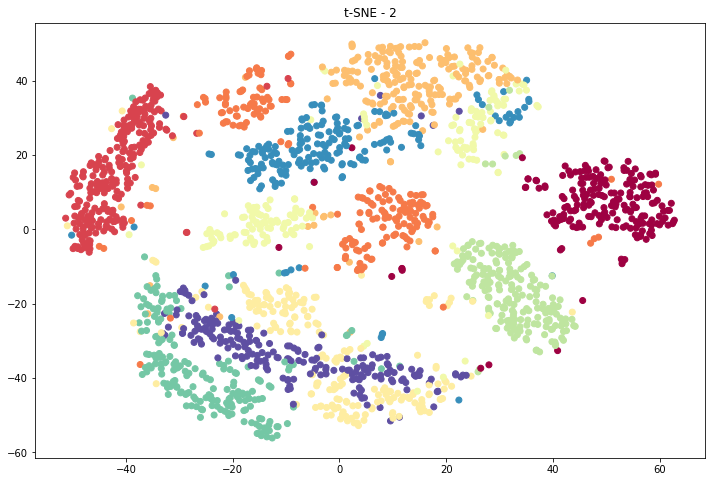

start transformation with t-SNE and 3 components
(2000, 3)
Start classification


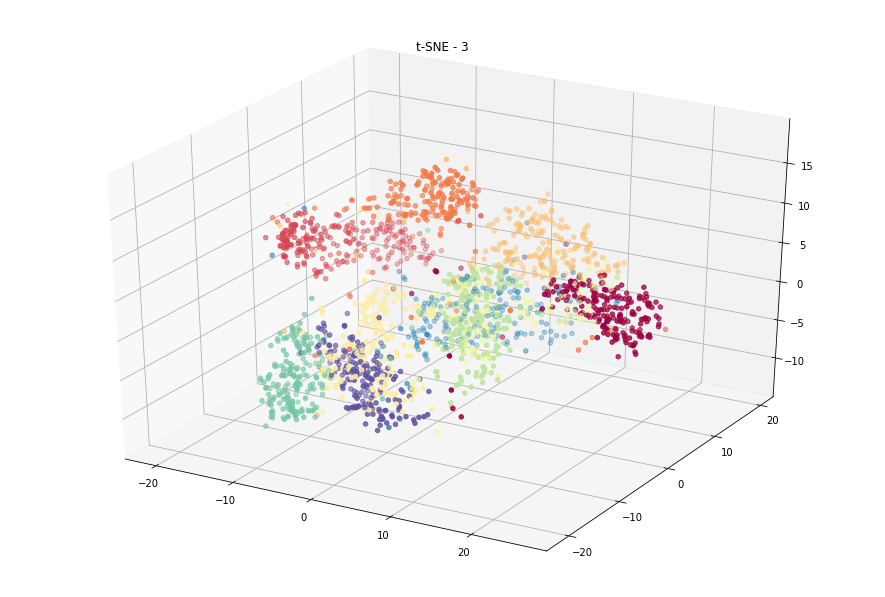

start transformation with LLE and 2 components
(2000, 2)
Start classification


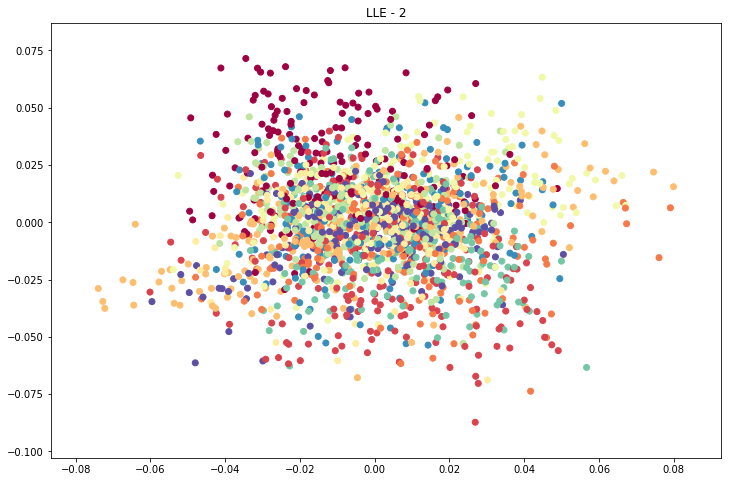

start transformation with LLE and 3 components
(2000, 3)
Start classification


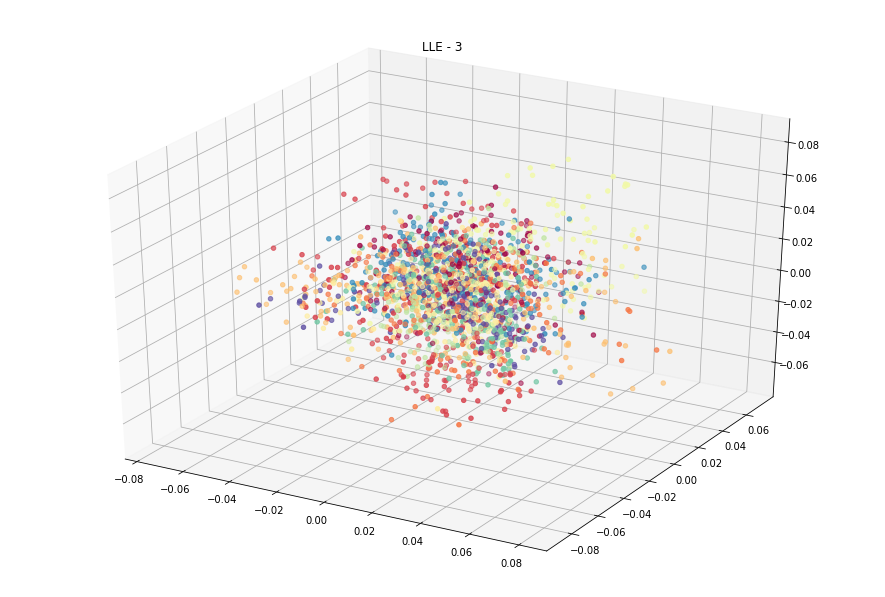

(5000, 50)
(1340, 3) (1340,)
start transformation with PCA and 2 components
(5000, 2)
Start classification


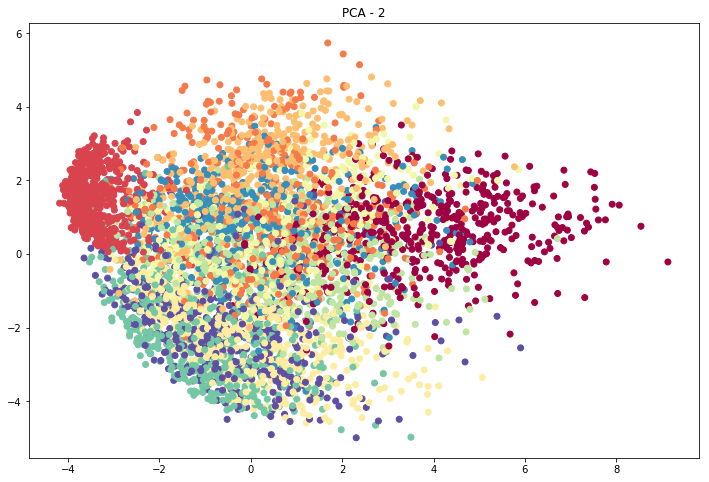

start transformation with PCA and 3 components
(5000, 3)
Start classification


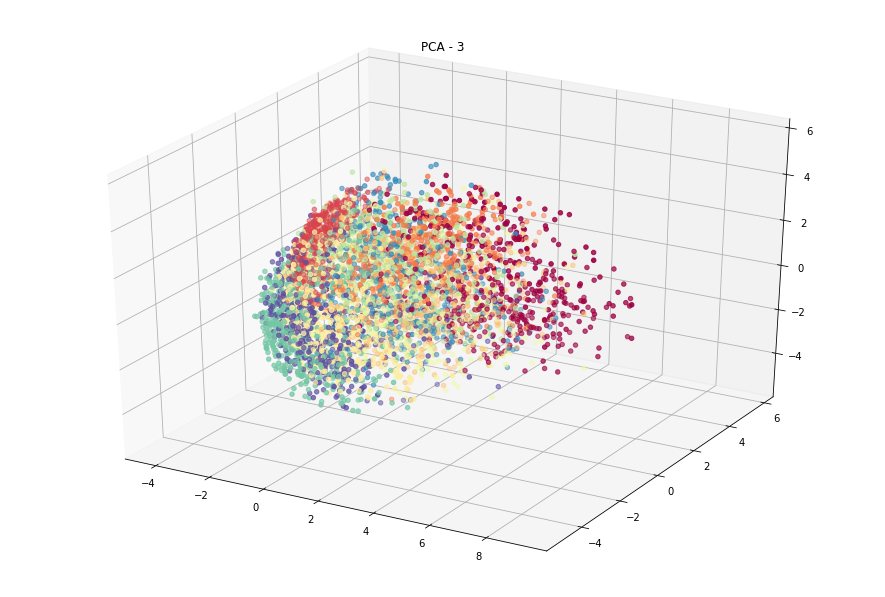

start transformation with MDS and 2 components
(5000, 2)
Start classification


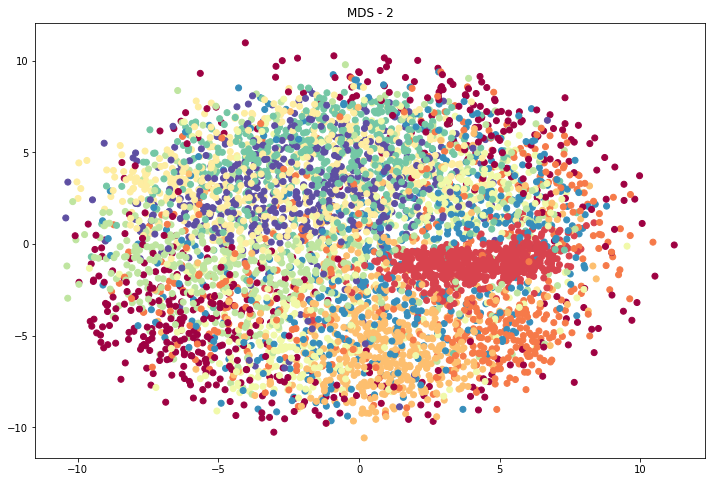

start transformation with MDS and 3 components
(5000, 3)
Start classification


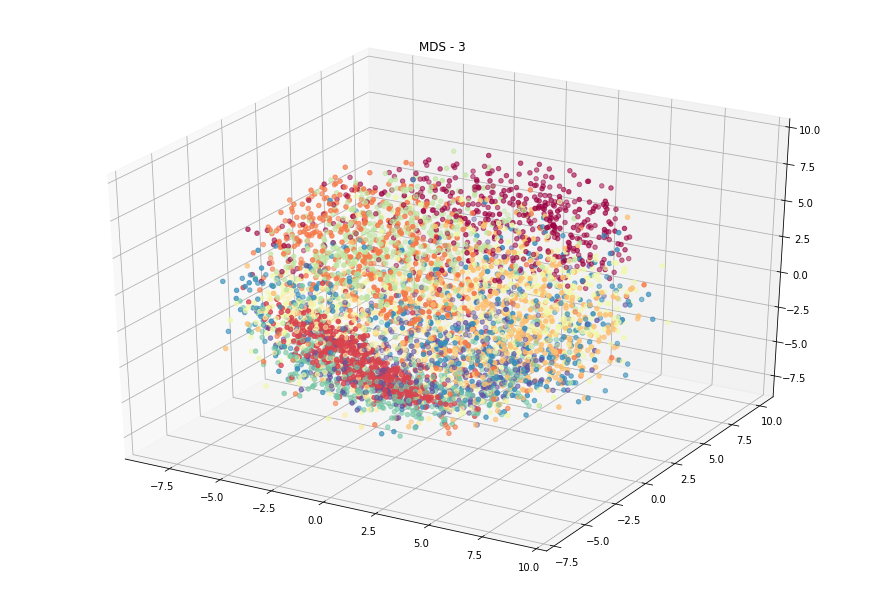

start transformation with Isomap and 2 components
(5000, 2)
Start classification


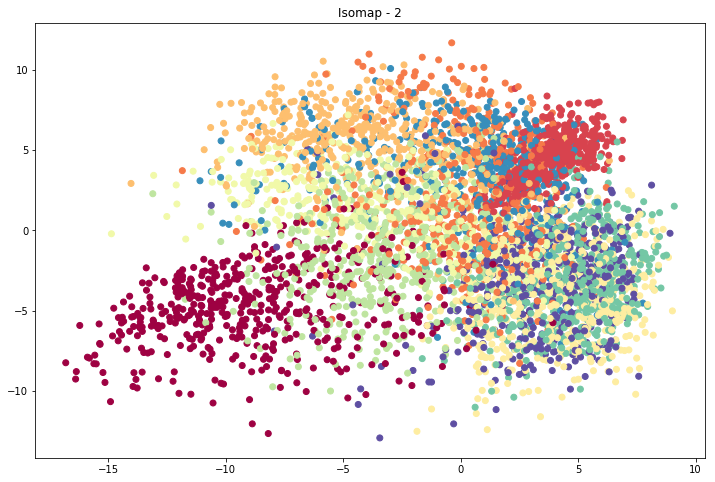

start transformation with Isomap and 3 components
(5000, 3)
Start classification


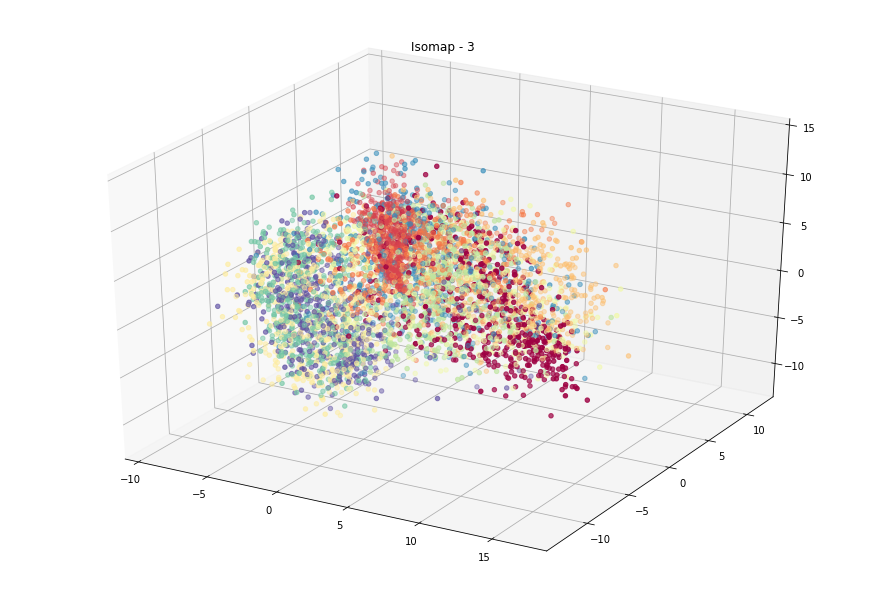

start transformation with t-SNE and 2 components
(5000, 2)
Start classification


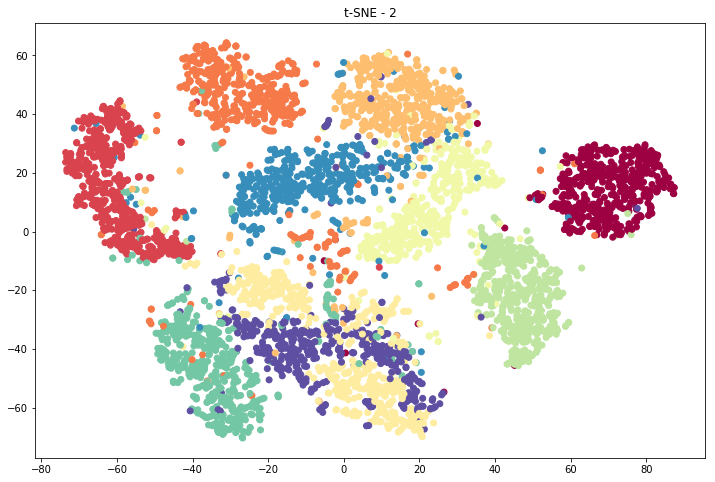

start transformation with t-SNE and 3 components
(5000, 3)
Start classification


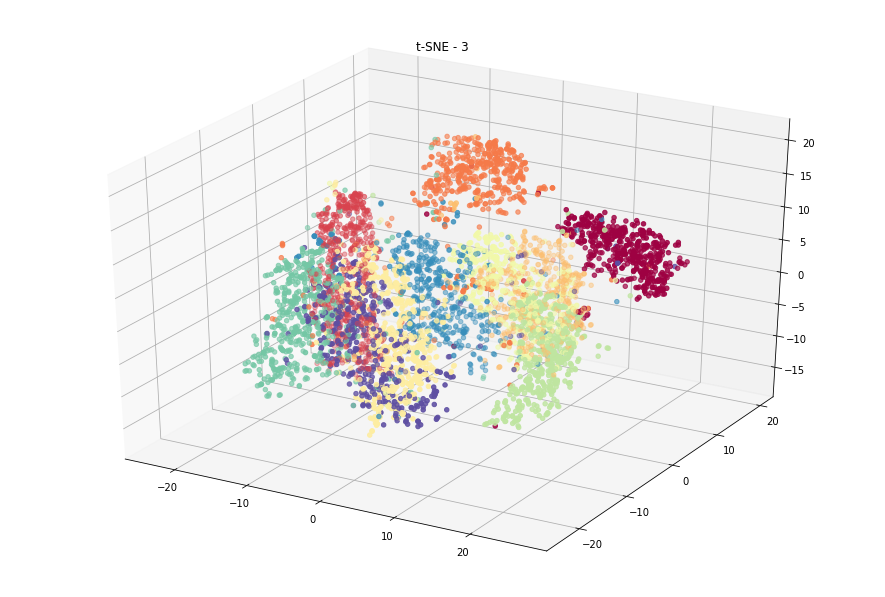

start transformation with LLE and 2 components
(5000, 2)
Start classification


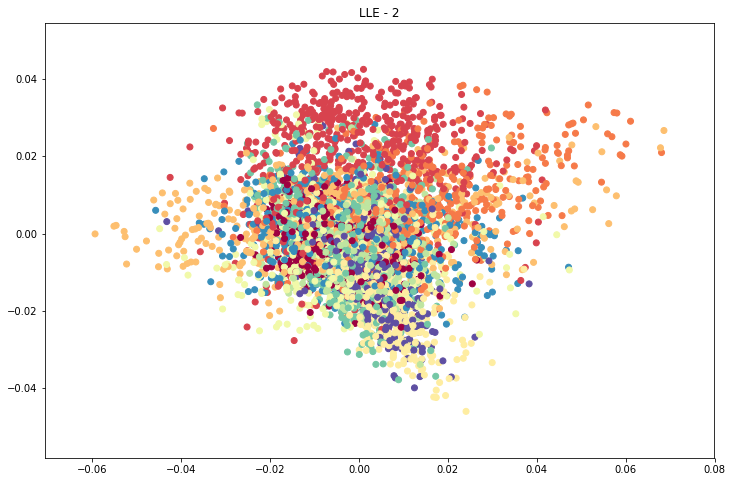

start transformation with LLE and 3 components
(5000, 3)
Start classification


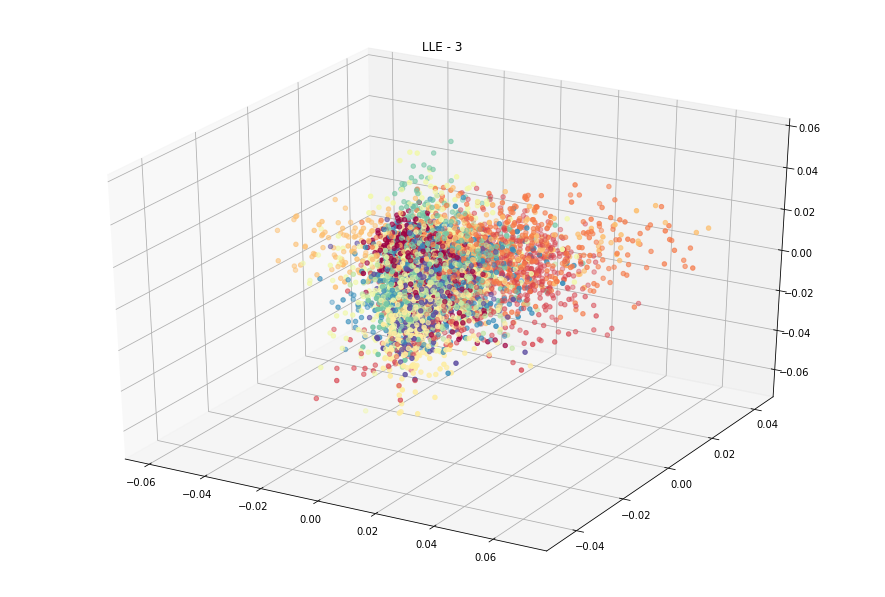

In [28]:
# data_sizes = [100, 200, 500]
data_sizes = [1000, 2000, 5000]
possible_n_components = [2, 3]
n_neighbors = 15 

d_method_classes = {
    "PCA": decomposition.PCA,
    "MDS": manifold.MDS,
    "Isomap": manifold.Isomap,
    "t-SNE": manifold.TSNE,
    "LLE": manifold.LocallyLinearEmbedding
}
d_method_param = {
    "PCA": {},
    "MDS": {"n_init":1},
    "Isomap": {"n_neighbors":75},
    "t-SNE": {"init":'pca'},
    "LLE": {"n_neighbors":75}
}

d_method_times = {
    "PCA": [],
    "MDS": [],
    "Isomap": [],
    "t-SNE": [],
    "LLE": []
}

d_method_accuracy = {
    "PCA": [],
    "MDS": [],
    "Isomap": [],
    "t-SNE": [],
    "LLE": []
} 

for data_size in data_sizes:
    shuffled_indexes = np.random.permutation(X.shape[0]) # les indices mélangés du jeu de données
    X_sub, y_sub = X[shuffled_indexes[:data_size]], y[shuffled_indexes[:data_size]]
    
    init_pca_transformer = decomposition.PCA(50)
    X_sub = init_pca_transformer.fit_transform(X_sub)
    print(X_sub.shape)
    print(X_train.shape, y_train.shape)
    for transfo_class_name, transfo_class in d_method_classes.items():
        for n_comp in possible_n_components:
            transfo_obj = transfo_class(n_components=n_comp, **d_method_param[transfo_class_name])
            print(f"start transformation with {transfo_class_name} and {n_comp} components")
            start_transfo_time = time.time()
            trans_X = transfo_obj.fit_transform(X_sub)
            print(trans_X.shape)
            end_transfo_time = time.time()
            X_train, X_test, y_train, y_test = train_test_split(trans_X, y_sub, test_size=0.33)
            print("Start classification")
            clf = neighbors.KNeighborsClassifier(n_neighbors) 
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test) 
            accuracy = accuracy_score(y_test, y_pred)
            d_method_times[transfo_class_name].append(end_transfo_time - start_transfo_time)
            d_method_accuracy[transfo_class_name].append(accuracy)
            if n_comp == 2:
                scatter2D(trans_X[:, 0], trans_X[:, 1], title=f"{transfo_class_name} - {n_comp}", colors=y_sub)
            if n_comp == 3:
                scatter3D(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], title=f"{transfo_class_name} - {n_comp}", colors=y_sub)
            
            
#     X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.33)

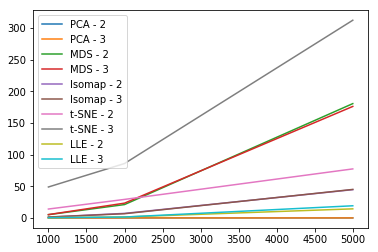

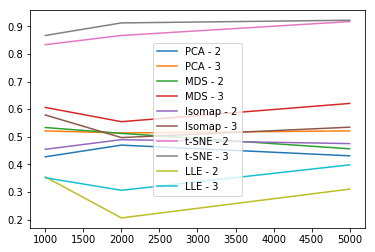

In [29]:
for method in d_method_times.keys():
    for i, n_comp in enumerate(possible_n_components):
        arr_method_id = np.array((0, 2, 4)) + i
        arr_method_times = np.array(d_method_times[method])[arr_method_id]
        plt.plot(data_sizes, arr_method_times, label=f"{method} - {n_comp}")
plt.legend()
plt.show()

for method in d_method_times.keys():
    for i, n_comp in enumerate(possible_n_components):
        arr_method_id = np.array((0, 2, 4)) + i
        arr_method_acc = np.array(d_method_accuracy[method])[arr_method_id]
        plt.plot(data_sizes, arr_method_acc, label=f"{method} - {n_comp}")
plt.legend()
plt.show()

### Qui veut un 22/20? (Exercice Bonus optionnel: Validation du nombre de voisins)

*Ce sera assez long je pense, ne le faites que si vous êtes intéressés par aller plus loin et si vous avez du temps: aucune pénalité ne sera retenue si vous ne le faites pas... mais lisez quand même*

Vous avez dû constater qu'au cours de ce module, à chaque fois que nous avons utilisé la notion de voisins, nous avons pris un nombre de voisin sans vraiment l'expliquer: pourquoi ce nombre précis et pas un autre? Est-ce que ça aurait moins bien ou mieux marché avec plus ou moins de voisins? Je vous le dis directement: on a choisi au pif.

**MAIS**

on aurait pu le faire proprement, en utilisant un jeu de données de validation.

L'idée c'est qu'il existe un nombre de voisin idéal pour une technique donnée et un jeu de donnée en particulier. La méthode la plus directe est d'essayer plein de nombre de voisins différents sur le jeu de données *test* et de prendre le nombre de voisin qui fonctionne le mieux ici. Ensuite, on donne le meilleur résultat obtenu avec le nombre de voisin idéal. **Il ne faut surtout pas faire ça**. 

Le problème de cette méthode est qu'elle est contraire au principe de généralisation (extrêmement important en apprentissage automatique). En effet, l'idée de l'apprentissage (supervisé, ici), c'est qu'à partir de données étiquettées, on peut apprendre un modèle (pour la classification, par exemple) qui sera capable de généraliser à des données inconnues. 

Les données étiquettées, c'est l'échantillon *train* et les données inconnues, c'est l'échantillon *test*. Le seul moment où on peut utiliser les étiquettes de l'échantillon *test*, c'est pour l'évaluation finale. Donc si vous utilisez l'échantillon *test* pour choisir le nombre de plus proche voisins qu'il vous faut... ben vous vous êtes servis des étiquettes de *test* pour construire votre modèle, et ça, c'est pas bien. Bouh!

Alors? Comment on fait? Une méthode simple consiste tout simplement à diviser l'échantillon *train* en un sous échantillon train et un échantillon de validation. Ensuite, on utilise l'échantillon de validation pour trouver le nombre de plus proches voisins qui fonctionne le mieux. Quand on a choisi le nombre idéal, on peut enfin faire l'évaluation sur les données inconnues de l'échantillon test!

**Exercice** (l'utilisation de boucles et de fonctions est très conseillée)
- Diviser le jeu de données train en un échantillon train et un échantillon de validation (90%/10%);
- Pour les méthodes qui le nécessitent, choisir les nombre de voisins qui fonctionnent le mieux en validation;
- En utilisant ces nombres de voisins, refaire l'exercice principal. Attention, le sous-echantillon de validation ne doit plus être utilisé (pour toutes les méthodes) pour l'entrainement.

Pour aller encore plus loin, vous pouvez jeter un oeil à la validation croisée qui consiste à faire plusieurs fois ce qu'on vient de voir en utilisant différents ensembles de *train* et de validation et en moyennant les résultats obtenus.